# Прогнозирование оттока клиентов оператора связи

### Описание проекта
##### Цель: 
Оператору связи «Ниединогоразрыва.ком» необходимо научисться прогнозировать отток клиентов для применения упреждающих мер по удержанию клиентов (предложение промокодов и специальных условий). 

Для выборки клиентов доступны персональные данные о некоторых клиентах, информация об их тарифах и договорах.

Информация о договорах актуальна на 1 февраля 2020.

### Описание Услуг
- Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию DSL или оптоволоконный кабель Fiber optic.

#### Дополнительные услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных
Данные состоят из файлов, полученных из разных источников:
- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

## 1. Исследовательский анализ данных

### 1.1 Загрузка библиотек и  данных

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.subplots import make_subplots
import seaborn as sns
import numpy as np
import math
pd.set_option('display.max_columns', 100)
sns.set()
import plotly

from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve, confusion_matrix

from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings('ignore')

#константы заглавными букваит
RANDOM_STATE = 121222

In [2]:
#contract = pd.read_csv('/datasets/final_provider/contract.csv')
#personal = pd.read_csv('/datasets/final_provider/personal.csv')
#internet = pd.read_csv('/datasets/final_provider/internet.csv')
#phone = pd.read_csv('/datasets/final_provider/phone.csv')

contract = pd.read_csv('/Users/Mikalai/Documents/Data Science/Выпускной проект/contract.csv')
personal = pd.read_csv('/Users/Mikalai/Documents/Data Science/Выпускной проект/personal.csv')
internet = pd.read_csv('/Users/Mikalai/Documents/Data Science/Выпускной проект/internet.csv')
phone = pd.read_csv('/Users/Mikalai/Documents/Data Science/Выпускной проект/phone.csv')

### 1.2 Изучение и предобработка данных таблицы contract

#### 1.2.1 Изучение данных таблицы contract

In [3]:
display(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

In [4]:
display(contract.head(15))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [5]:
display(contract.describe(include = 'all')) 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Проверим данные на дубликаты по коду клиента

In [6]:
print('Дублирующих строк таблицы contract:', contract['customerID'].duplicated().sum())

Дублирующих строк таблицы contract: 0


Проверим данные на пропуски

In [7]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Таблица contract содержит 7043 строки и 8 столбцов. Пропусков и дубликатов нет.

В таблице contract представлена информация о договорах, и включает:
- customerID - уникальный ID клиента
- BeginDate - дата начала пользования услугами
- EndDate - дата окончания пользования услугами
- Type - тип оплаты: ежемесячный, годовой и т.д.
- PaperlessBilling - безбумажная оплата или нет
- PaymentMethod - способы оплаты за услуги
- MonthlyCharges - ежемесячные траты на услуги 
- TotalCharges - всего потрачено денег на услуги

По результату ознокомления с данными таблицы contract определяем необходимые действия по предобработке данных:
- привести названия столбцов в соответствие с хорошим стилем
- изменить тип данных в столбцах Type, PaperlessBilling, PaymentMethod на категориальный
- тип данных в столбце BeginDate привести к типу date
- тип данных в столбце EndDate привести к типу date
- если в столбце EndDate дата расторжения договора обозначенена как 'No', то это значит что на момент выгрузки данных договор не расторгнут. Поэтому заменим данные в столбце EndDate с обозначением 'No' на дату выгрузки данных '2020-02-01'
- тип данных в столбце TotalCharges привести к типу float

#### 1.2.2 Предобработка данных таблицы contract

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Названия столбцов приводим в соответствие с хорошим стилем

In [9]:
contract = contract.rename(columns = {'customerID':'customer_id',
                                                'BeginDate' : 'begin_date',
                                                'EndDate' : 'end_date',
                                                'Type' : 'billing_type',
                                                'PaperlessBilling' : 'paperless_billing',
                                                'PaymentMethod' : 'payment_method',
                                                'MonthlyCharges' : 'monthly_charges',
                                                'TotalCharges' : 'total_charges'})
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   billing_type       7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Изменение типа данных в столбцах на категориальный

In [10]:
contract['billing_type'] = contract['billing_type'].astype('category')
contract['payment_method'] = contract['payment_method'].astype('category')
contract['paperless_billing'] = contract['paperless_billing'].astype('category')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        7043 non-null   object  
 1   begin_date         7043 non-null   object  
 2   end_date           7043 non-null   object  
 3   billing_type       7043 non-null   category
 4   paperless_billing  7043 non-null   category
 5   payment_method     7043 non-null   category
 6   monthly_charges    7043 non-null   float64 
 7   total_charges      7043 non-null   object  
dtypes: category(3), float64(1), object(4)
memory usage: 296.3+ KB


Приведение типа данных столбца begin_date к типу date

In [11]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
display(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   billing_type       7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: category(3), datetime64[ns](1), float64(1), object(3)
memory usage: 296.3+ KB


None

Если в столбце end_date дата расторжения договора обозначенена как 'No', то это значит что на момент выгрузки данных договор не расторгнут. Поэтому заменим данные в столбце end_date с обозначением 'No' на дату выгрузки данных '2020-02-01'

In [12]:
contract['end_date'] = contract['end_date'].replace(to_replace='No', value='2020-02-01')
display(contract['end_date'].unique())

array(['2020-02-01', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Приведение типа данных столбца end_date к типу date 

In [13]:
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')
display(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   billing_type       7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: category(3), datetime64[ns](2), float64(1), object(2)
memory usage: 296.3+ KB


None

Изменение типа данных в столбце total_charges к типу float

In [14]:
contract['total_charges'] = pd.to_numeric(arg=contract['total_charges'], errors='coerce')
display(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   billing_type       7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: category(3), datetime64[ns](2), float64(2), object(1)
memory usage: 296.3+ KB


None

Появились для 11 клиентов пропуски значений total_charges. Посмотрим на пропуски

In [15]:
contract.sort_values(by='total_charges').tail(11)

,customer_id,begin_date,end_date,billing_type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


Видим, что это клиенты, которые только что подключились. У них имеютя значения месячного платежа monthly_charges. Заполним пропуски в total_charges на значения monthly_charges

In [16]:
total_charges_NaN = contract.sort_values(by='total_charges').tail(11)['total_charges'].index
contract.loc[total_charges_NaN]

,customer_id,begin_date,end_date,billing_type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


In [17]:
contract['total_charges'] = np.where(contract['total_charges'] > 0, \
                                       contract['total_charges'], contract['monthly_charges'])
contract.loc[total_charges_NaN]

,customer_id,begin_date,end_date,billing_type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,19.85
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,20.00
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,19.70
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,73.35


In [18]:
display(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   billing_type       7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: category(3), datetime64[ns](2), float64(2), object(1)
memory usage: 296.3+ KB


None

In [19]:
display(contract.head())

,customer_id,begin_date,end_date,billing_type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


### 1.3 Изучение и предобработка данных таблицы personal

#### 1.3.1 Изучение данных таблицы personal

In [20]:
display(personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

In [21]:
display(personal.head(10))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [22]:
display(personal.describe(include = 'all')) 

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [23]:
print('Дублирующих строк таблицы personal:', personal['customerID'].duplicated().sum())

Дублирующих строк таблицы personal: 0


In [24]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Таблица contract содержит 7043 строки и 5 столбцов. Пропусков и дубликатов нет.

В таблице personal представлена информация о клиентах, и включает:
- customerID - уникальный ID клиента
- gender - пол клиента
- SeniorCitizen - наличие пенсионного статуса по возрасту
- Partner - наличие супруга(и)
- Dependents - наличие иждивенцев

По результату ознокомления с данными таблицы personal определяем необходимые действия по предобработке данных:
- привести названия столбцов в соответствие с хорошим стилем
- изменить тип данных в столбцах gender, Partner, Dependents на категориальный 

#### 1.3.2 Предобработка данных таблицы personal

In [25]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Названия столбцов приводим в соответствие с хорошим стилем

In [26]:
personal = personal.rename(columns={'customerID' : 'customer_id',
                                              'SeniorCitizen' : 'senior_sitizen',
                                              'Partner' : 'partner',
                                              'Dependents' : 'dependents'})
display(personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_sitizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Изменение типа данных в столбцах  gender, partner, dependents на категориальный

In [27]:
personal['gender'] = personal['gender'].astype('category')
personal['partner'] = personal['partner'].astype('category')
personal['dependents'] = personal['dependents'].astype('category')
personal['senior_sitizen'] = personal['senior_sitizen'].astype('category')
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     7043 non-null   object  
 1   gender          7043 non-null   category
 2   senior_sitizen  7043 non-null   category
 3   partner         7043 non-null   category
 4   dependents      7043 non-null   category
dtypes: category(4), object(1)
memory usage: 83.1+ KB


In [28]:
display(personal.head(10))

,customer_id,gender,senior_sitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


### 1.4 Изучение и предобработка данных таблицы internet

#### 1.4.1 Изучение данных таблицы internet

In [29]:
display(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

In [30]:
display(internet.head())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [31]:
display(personal.describe(include = 'all')) 

,customer_id,gender,senior_sitizen,partner,dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,7590-VHVEG,Male,0,No,No
freq,1,3555,5901,3641,4933


In [32]:
print('Дублирующих строк таблицы internet:', internet['customerID'].duplicated().sum())

Дублирующих строк таблицы internet: 0


In [33]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Таблица internet содержит 5517 строки и 8 столбцов. Пропусков и дубликатов нет.

Количество записей в таблице internet меньше чем в таблицах personal и contract.  Вероятно таблицы personal и contract содержат записи о пользователях отказавшихся от услуг. 

В таблице internet представлена информация об интернет-услугах, и включает:
- customerID - уникальный ID клиента
- InternetService - варианты подключения интернет-соединения
- OnlineSecurity - услуга блокировки небезопасных сайтов
- OnlineBackup - услуга Облачного хранилища файлов
- DeviceProtection - наличие услуги антивируса
- TechSupport - услуга выделенной линии технической поддержки
- StreamingTV - услуга стримингового телевидения
- StreamingMovies - услуга каталога фильмов

По результату ознокомления с данными таблицы internet определяем необходимые действия по предобработке данных:
- привести названия столбцов в соответствие с хорошим стилем
- изменим тип данных в столбцах OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingTV  на категориальный 

#### 1.4.2 Предобработка данных таблицы internet

In [34]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Названия столбцов приводим в соответствие с хорошим стилем

In [35]:
internet = internet.rename(columns={'customerID' : 'customer_id',
                                              'InternetService' : 'internet_service',
                                              'OnlineSecurity' : 'online_security',
                                              'OnlineBackup' : 'online_backup',
                                              'DeviceProtection' : 'device_protection',
                                              'TechSupport' : 'tech_support',
                                              'StreamingTV' : 'streaming_tv',
                                              'StreamingMovies' : 'streaming_movies'})
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Изменение типа данных в столбце услуг на категориальный

In [36]:
cat_cols = ['online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv', 'streaming_movies']

for col in cat_cols:
    internet[col] = internet[col].astype('category')
    
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        5517 non-null   object  
 1   internet_service   5517 non-null   object  
 2   online_security    5517 non-null   category
 3   online_backup      5517 non-null   category
 4   device_protection  5517 non-null   category
 5   tech_support       5517 non-null   category
 6   streaming_tv       5517 non-null   category
 7   streaming_movies   5517 non-null   category
dtypes: category(6), object(2)
memory usage: 119.4+ KB


### 1.5 Изучение и предобработка данных таблицы phone

#### 1.5.1 Изучение данных таблицы phone

In [37]:
display(phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [38]:
display(phone.head())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [39]:
print('Дублирующих строк таблицы phone:', phone['customerID'].duplicated().sum())

Дублирующих строк таблицы phone: 0


In [40]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

Таблица phone содержит 6361 строки и 2 столбца. Пропусков и дубликатов нет.

Количество записей в таблице phone меньше чем в таблицах personal и contract. 

В таблице phone представлена информация об интернет-услугах, и включает:
- customerID - уникальный ID клиента
- MultipleLines - наличие возможности ведения параллельных линий во время звонка 

По результату ознокомления с данными таблицы phone определяем необходимые действия по предобработке данных:
- привести названия столбцов в соответствие с хорошим стилем
- заменим тип данных в столбце MultipleLines на категорийный

#### 1.5.2 Предобработка данных таблицы phone

Названия столбцов приводим в соответствие с хорошим стилем

In [41]:
phone = phone.rename(columns={'customerID' : 'customer_id',
                                        'MultipleLines' : 'multiple_lines'})
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [42]:
phone['multiple_lines'] = phone['multiple_lines'].astype('category')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        5517 non-null   object  
 1   internet_service   5517 non-null   object  
 2   online_security    5517 non-null   category
 3   online_backup      5517 non-null   category
 4   device_protection  5517 non-null   category
 5   tech_support       5517 non-null   category
 6   streaming_tv       5517 non-null   category
 7   streaming_movies   5517 non-null   category
dtypes: category(6), object(2)
memory usage: 119.4+ KB


In [43]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     6361 non-null   object  
 1   multiple_lines  6361 non-null   category
dtypes: category(1), object(1)
memory usage: 56.2+ KB


#### Выводы по ознакомлению и преобработке данных
- данные в таблицах не имеют пропусков и дубликатов
- названия столбцов привели в соответствие с хорошим стилем
- изменены типы данных таблиц

## 2. Анализ данных

Для анализа данных необходимо объединить все таблицы в одну общую

In [44]:
contract = contract.set_index(keys='customer_id')
personal = personal.set_index(keys='customer_id')
internet = internet.set_index(keys='customer_id')
phone = phone.set_index(keys='customer_id')

In [45]:
contract.info()
personal.info()
internet.info()
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   billing_type       7043 non-null   category      
 3   paperless_billing  7043 non-null   category      
 4   payment_method     7043 non-null   category      
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
dtypes: category(3), datetime64[ns](2), float64(2)
memory usage: 296.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   gender          7043 non-null   category
 1   senior_sitizen  7043 non-null   category
 2   partner  

In [46]:
data = contract.join(personal)\
                    .join(internet)\
                    .join(phone)
display(data.head())

,begin_date,end_date,billing_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_sitizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   billing_type       7043 non-null   category      
 3   paperless_billing  7043 non-null   category      
 4   payment_method     7043 non-null   category      
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   category      
 8   senior_sitizen     7043 non-null   category      
 9   partner            7043 non-null   category      
 10  dependents         7043 non-null   category      
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   category      
 13  online_backup      5517 non-null   category      
 14

Имеются пропуски значний в столбцах с услугами online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, а также в столбце internet_service (варианты подключения интернет-соединения) и столбце multiple_lines (мультиканальная линия или нет).

Пропуски значний в столбцах с услугами заменим на 'No' так услуга не предоставляется. Также 'No' заполним пропуски в столбце multiple_lines, предположив что данные клиенты не имеют подключения по мультиканальной линии.

In [48]:
passes_cols = ['online_security', 'online_backup', 'device_protection', 'tech_support',
               'streaming_tv', 'streaming_movies', 'multiple_lines']

for col in passes_cols:
    data[col] = data[col].fillna(value='No')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   billing_type       7043 non-null   category      
 3   paperless_billing  7043 non-null   category      
 4   payment_method     7043 non-null   category      
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   category      
 8   senior_sitizen     7043 non-null   category      
 9   partner            7043 non-null   category      
 10  dependents         7043 non-null   category      
 11  internet_service   5517 non-null   object        
 12  online_security    7043 non-null   category      
 13  online_backup      7043 non-null   category      
 14

Для замены пропусков в столбце internet_service посмотрим на уникальные значения 

In [49]:
data['internet_service'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

Видим, что клиенты получают интернет или по телефонной линии DSL или оптоволокому кабелю Fiber optic. Можно предположить, что пропуски указывают на то, клиенты не используются интернет сервис.

In [50]:
data['internet_service'] = data['internet_service'].fillna('Не используется')
data['internet_service'] = data['internet_service'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   billing_type       7043 non-null   category      
 3   paperless_billing  7043 non-null   category      
 4   payment_method     7043 non-null   category      
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   category      
 8   senior_sitizen     7043 non-null   category      
 9   partner            7043 non-null   category      
 10  dependents         7043 non-null   category      
 11  internet_service   7043 non-null   category      
 12  online_security    7043 non-null   category      
 13  online_backup      7043 non-null   category      
 14

Пропуски заполнены.

Создадим новый признак - продолжительность контракта с клиентом duration_contract 

In [51]:
data['duration_contract'] = (data['end_date'] - data['begin_date']).astype('timedelta64[D]')
data['duration_contract'] = data['duration_contract'].astype('int')
display(data.head())

,begin_date,end_date,billing_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_sitizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_contract
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61


Создадим столбец с годом начала предоставления услуг клиенту

In [52]:
data['begin_year'] = pd.DatetimeIndex(data['begin_date']).year
display(data.head())

,begin_date,end_date,billing_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_sitizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_contract,begin_year
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,2020
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,2017
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,2019
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,2016
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,2019


Выделим целевой признак

In [53]:
actual_date = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
data['client_left'] = data['end_date'].apply(lambda x: 1 if x<actual_date else 0)

Проверим выделение целевого признака

In [54]:
display(data[['end_date','client_left']].query('end_date < @actual_date'))
display(data[['end_date','client_left']].query('end_date == @actual_date'))

,end_date,client_left
customer_id,,
3668-QPYBK,2019-12-01,1
9237-HQITU,2019-11-01,1
9305-CDSKC,2019-11-01,1
7892-POOKP,2019-11-01,1
0280-XJGEX,2019-10-01,1
...,...,...
1699-HPSBG,2019-11-01,1
8775-CEBBJ,2019-11-01,1
6894-LFHLY,2019-11-01,1


,end_date,client_left
customer_id,,
7590-VHVEG,2020-02-01,0
5575-GNVDE,2020-02-01,0
7795-CFOCW,2020-02-01,0
1452-KIOVK,2020-02-01,0
6713-OKOMC,2020-02-01,0
...,...,...
2569-WGERO,2020-02-01,0
6840-RESVB,2020-02-01,0
2234-XADUH,2020-02-01,0


In [55]:
display(data.head())

,begin_date,end_date,billing_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_sitizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_contract,begin_year,client_left
customer_id,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,2020,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,2017,0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,2019,1
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,2016,0
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,2019,1


Посмотрим на распределение целевого признака

In [56]:
data['client_left'].value_counts()

0    5174
1    1869
Name: client_left, dtype: int64

0    0.73463
1    0.26537
Name: client_left, dtype: float64


<AxesSubplot:>

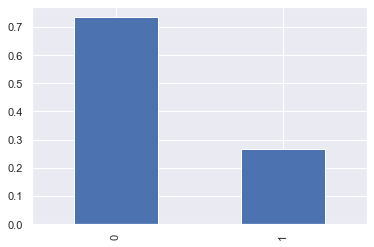

In [57]:
class_frequency = data['client_left'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Целевой признак распределён в примерно в сооотношении 3:1. Необходимо учесть дисбаланс при обучении модели

Посмотрим корреляцию между количественными признаками

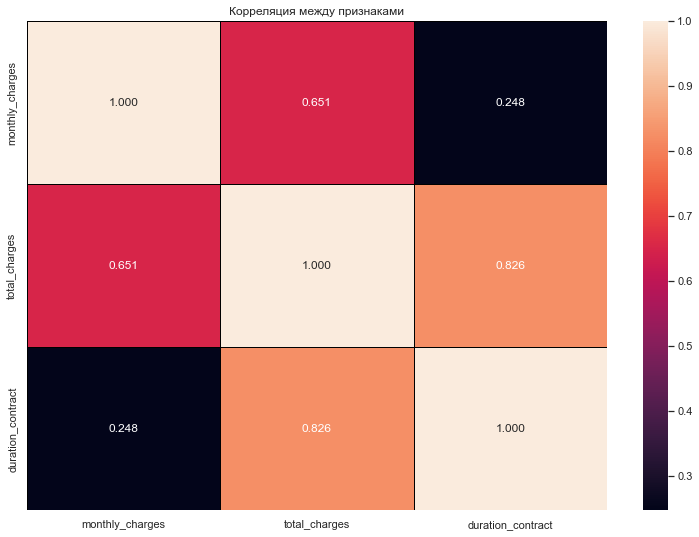

In [58]:

plt.figure(figsize=(13,9))
sns.heatmap(data.loc[:, ['monthly_charges','total_charges','duration_contract']].corr(), annot=True, fmt=".3f", linewidths=.5,linecolor='black')
plt.title("Корреляция между признаками")
plt.show()

Видим, что сильная корреляция наблюдается между признакаями duration_contract и total_charges. monthly_charges и total_charges скоррелированы довольно средне. Удалим признак total_charges, чтобы он не мешал модели.

Посмотрим на гистограмму ушедших клиентов по году их подключения

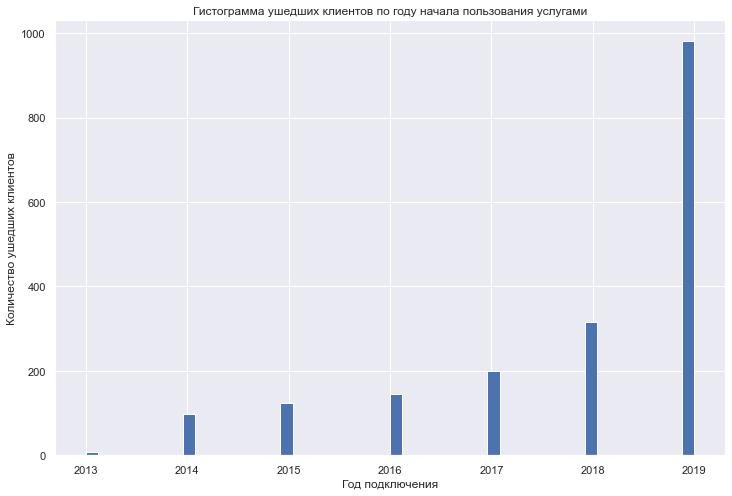

In [59]:
plt.figure(figsize=(12,8))
data.query('client_left == 1')['begin_year'].plot(kind='hist', bins=50, grid=True)
plt.title('Гистограмма ушедших клиентов по году начала пользования услугами')
plt.xlabel('Год подключения')
plt.ylabel('Количество ушедших клиентов')
plt.show()

На графике видим, что действительно последнее время от оператора начали уходить клиенты.

Построим распределения длительности пользования услугами для дейструющих и ушедших клиентов.

Text(0.5, 1.0, 'Клиент ушел')

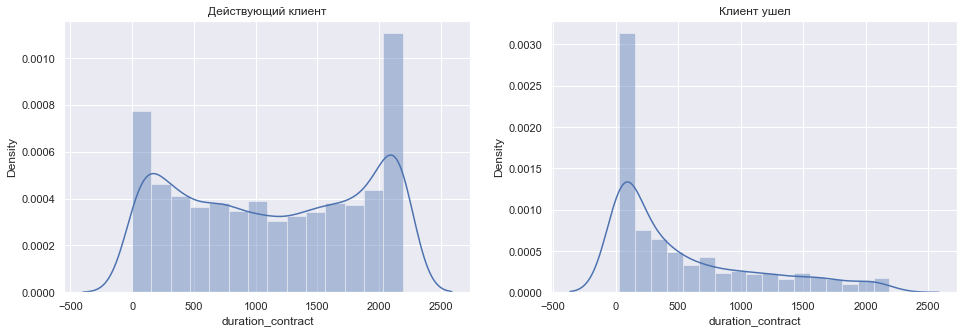

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.distplot(data[data['client_left'] == 0]['duration_contract'], ax = ax1).set_title('Действующий клиент')
sns.distplot(data[data['client_left'] == 1]['duration_contract'], ax = ax2).set_title('Клиент ушел')

Большинство клиентов уходит в первый год. Маркетингу надо обратить на это внимание. Таких клиентов нужно удерживать

Построим распределения месячной оплаты для действующих и ушедших клиентов.

Text(0.5, 1.0, 'Клиент ушел')

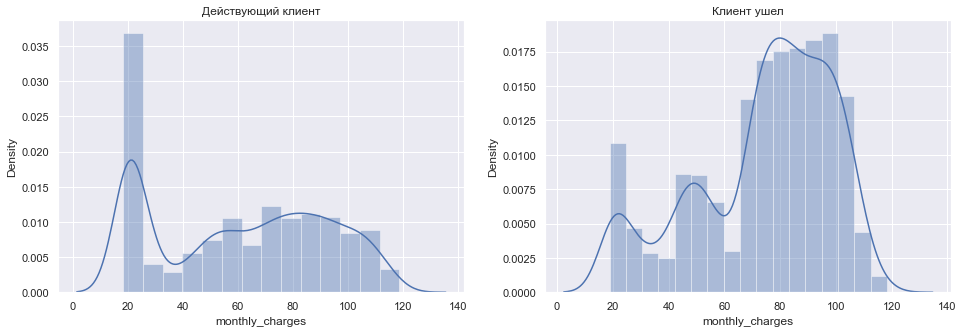

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.distplot(data[data['client_left'] == 0]['monthly_charges'], ax = ax1).set_title('Действующий клиент')
sns.distplot(data[data['client_left'] == 1]['monthly_charges'], ax = ax2).set_title('Клиент ушел')

Это важный признак. Чаще всего уходили клиенты, у которых месячные платежи были больше.

Для анализа распределения категорийных признаков выделим все категории и целевой признак в отдельный DataFrame

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   billing_type       7043 non-null   category      
 3   paperless_billing  7043 non-null   category      
 4   payment_method     7043 non-null   category      
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   category      
 8   senior_sitizen     7043 non-null   category      
 9   partner            7043 non-null   category      
 10  dependents         7043 non-null   category      
 11  internet_service   7043 non-null   category      
 12  online_security    7043 non-null   category      
 13  online_backup      7043 non-null   category      
 14

In [63]:
data_categorial = data.drop(['begin_date', 'end_date', 'monthly_charges', 'total_charges', 
                             'duration_contract', 'begin_year'], axis = 1)
data_categorial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   billing_type       7043 non-null   category
 1   paperless_billing  7043 non-null   category
 2   payment_method     7043 non-null   category
 3   gender             7043 non-null   category
 4   senior_sitizen     7043 non-null   category
 5   partner            7043 non-null   category
 6   dependents         7043 non-null   category
 7   internet_service   7043 non-null   category
 8   online_security    7043 non-null   category
 9   online_backup      7043 non-null   category
 10  device_protection  7043 non-null   category
 11  tech_support       7043 non-null   category
 12  streaming_tv       7043 non-null   category
 13  streaming_movies   7043 non-null   category
 14  multiple_lines     7043 non-null   category
 15  client_left        7043 non-null   int64   
d

In [64]:
display(data_categorial.head())

,billing_type,paperless_billing,payment_method,gender,senior_sitizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left
customer_id,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
5575-GNVDE,One year,No,Mailed check,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,Month-to-month,Yes,Mailed check,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
7795-CFOCW,One year,No,Bank transfer (automatic),Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
9237-HQITU,Month-to-month,Yes,Electronic check,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


Построим графики распределения категорийных признаков

In [65]:
data_categorial_list = list(data_categorial.columns)[0:14]
data_categorial_list.append('client_left')
data_categorial_list

['billing_type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_sitizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'client_left']

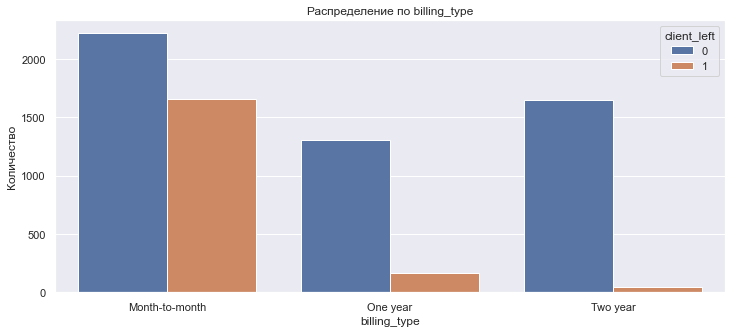

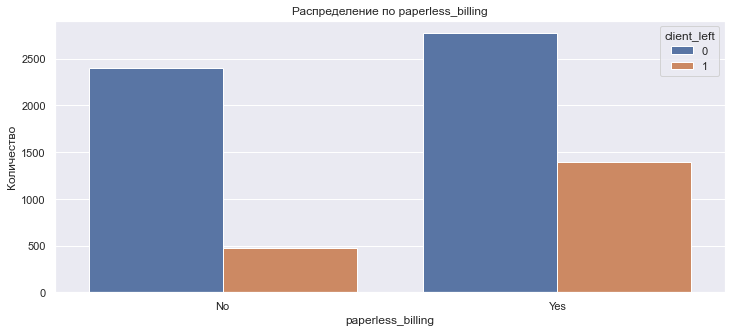

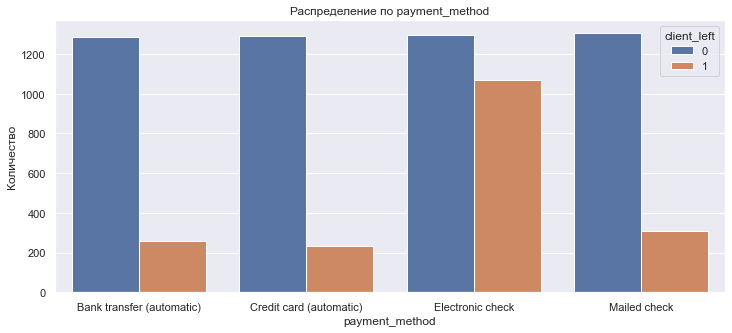

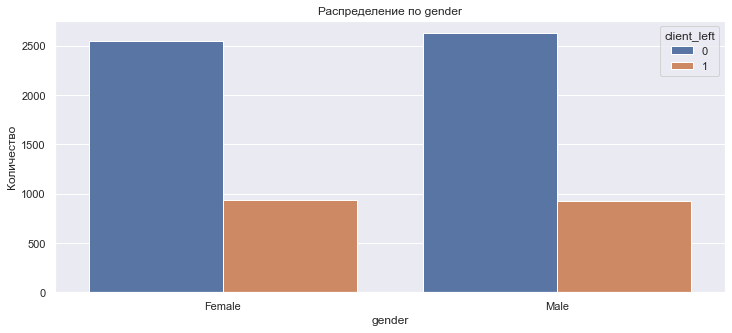

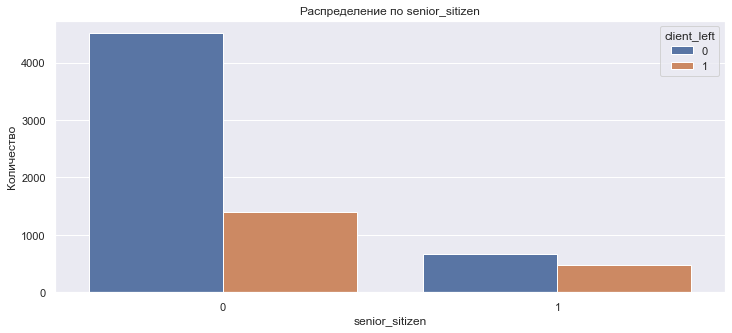

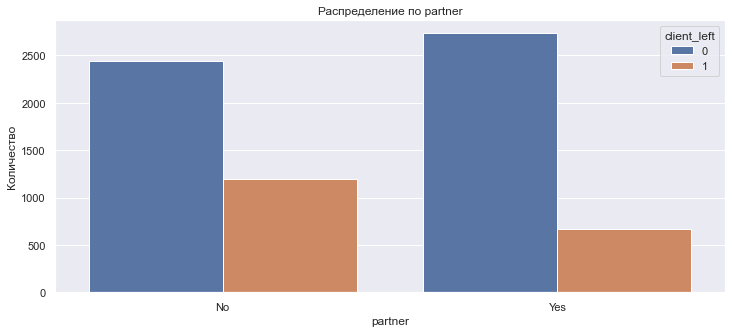

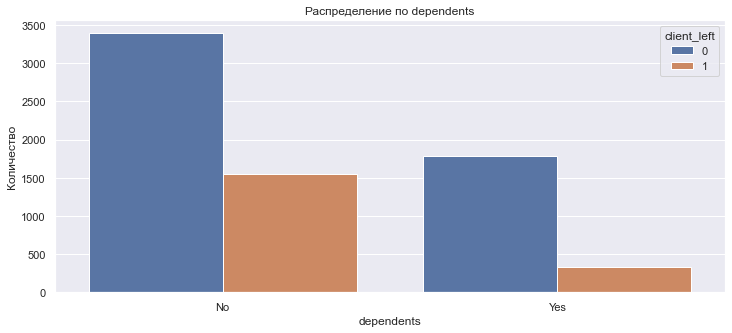

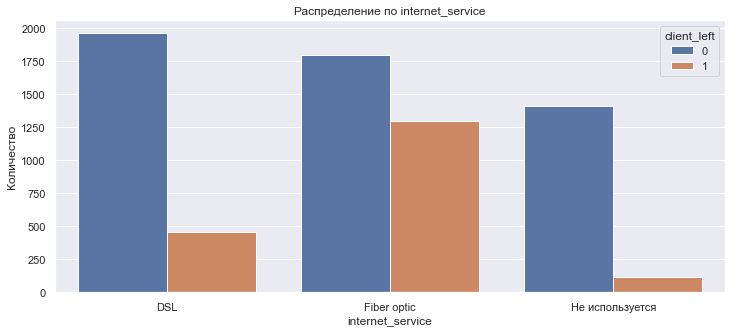

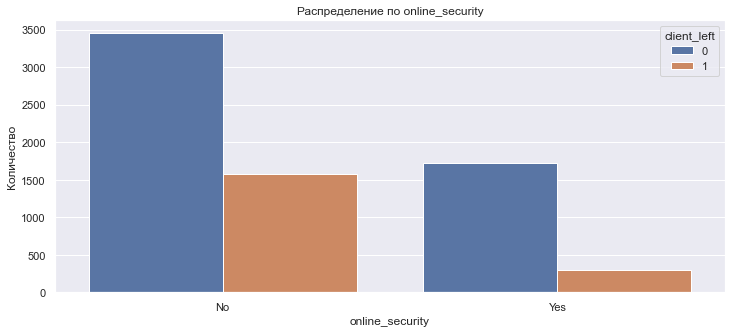

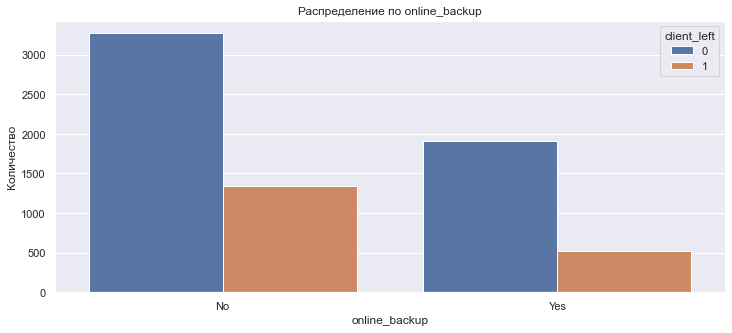

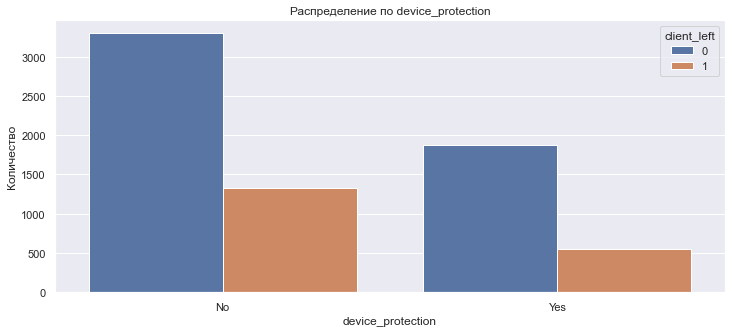

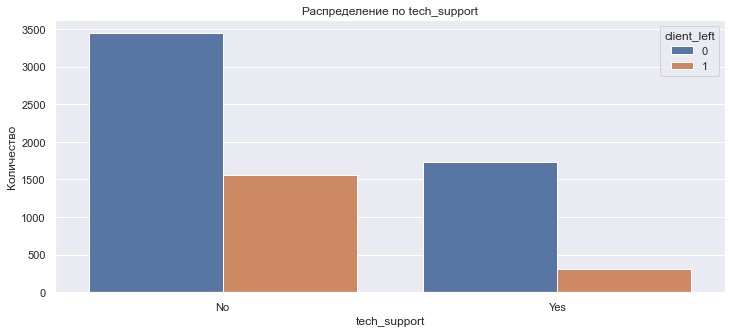

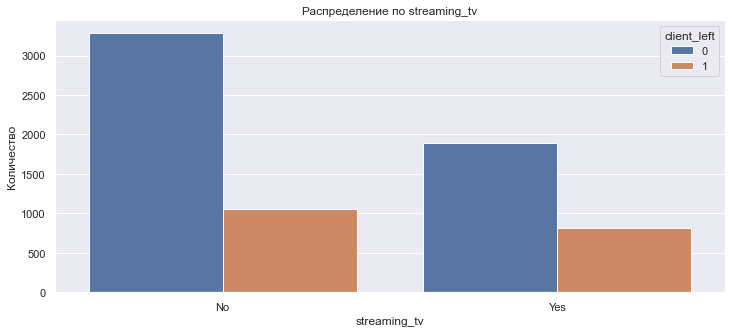

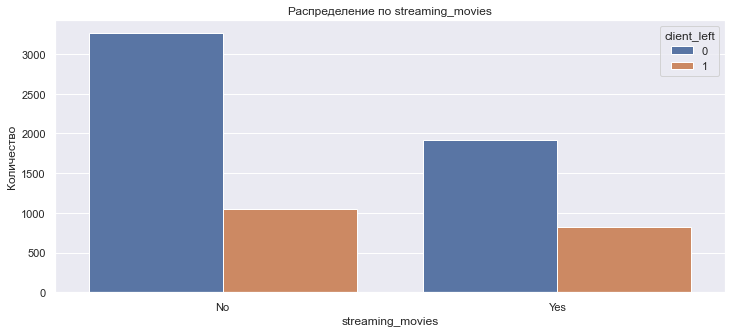

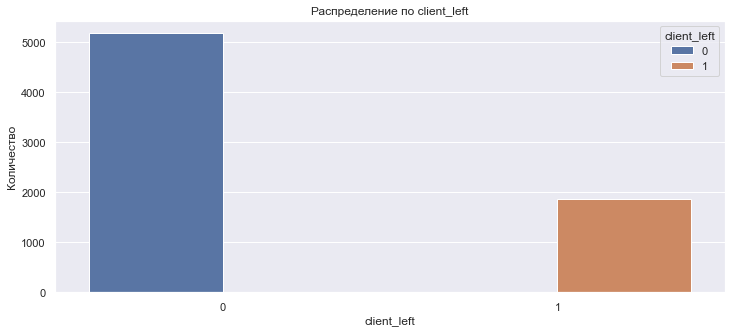

In [66]:
for column in data_categorial_list:
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.xticks(rotation=0)
    sns.countplot(x=column, hue= 'client_left', data=data_categorial)
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Количество');    

Из графиков рапределения категорийных признаков определим их важность для обучении моделей
1. Важные признаки
- billing_type
- paperless_billing
- payment_method
- internet_service
- dependents
- senior_sitizen
- online_security
- online_backup
- device_protection
2. Имеется некоторое влияние признака на целевой признак
- partner
- tech_support
- streaming_tv
- streaming_movies
- multiple_lines
3. Признак не важен (можно удалить)
- gender 

Теперь можем убрать не нужные признаки
- monthly_charges, total_charges - удаляем ввиду сильной корреляции с длительностью контракта
- begin_year - удаляем как фактор времени
- end_date - удаляем как фактор времени
- begin_year - столбец с годом начала предоставления услуг клиенту
- gender - не имеет влияния на целевой признак 

In [67]:
data = data.drop(['begin_date', 'end_date', 'total_charges', 'monthly_charges', 'begin_year', 'gender'], axis = 1)
display(data.head())

,billing_type,paperless_billing,payment_method,senior_sitizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_contract,client_left
customer_id,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
5575-GNVDE,One year,No,Mailed check,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
7795-CFOCW,One year,No,Bank transfer (automatic),0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
9237-HQITU,Month-to-month,Yes,Electronic check,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   billing_type       7043 non-null   category
 1   paperless_billing  7043 non-null   category
 2   payment_method     7043 non-null   category
 3   senior_sitizen     7043 non-null   category
 4   partner            7043 non-null   category
 5   dependents         7043 non-null   category
 6   internet_service   7043 non-null   category
 7   online_security    7043 non-null   category
 8   online_backup      7043 non-null   category
 9   device_protection  7043 non-null   category
 10  tech_support       7043 non-null   category
 11  streaming_tv       7043 non-null   category
 12  streaming_movies   7043 non-null   category
 13  multiple_lines     7043 non-null   category
 14  duration_contract  7043 non-null   int32   
 15  client_left        7043 non-null   int64   
d

#### Вывод:

В ходе выполнения исследовательского анализа данных
- загрузили и ознакомились с данными, провели предобратобку
- явных аномалий в в признаках не выявлено
- привели типы данных к нужным
- заполнили пропуски
- добавили новые признаки
- объединили таблицы в один DataFrame
- выделели целевой признак. Целевой признак не сбалансирован. Это надо учесть при обучении моделей
- привели анализ влияния признаков на целевой признак. Определили важные признаки для обучении моделей
- ненужные признаки удалили

## 3. Моделирование

### 3.1 Кодирование и масштабирование данных/разделение данных на треновочный и тестовый наборы

Разделим данные на треновочный и тестовый наборы

In [69]:
features = data.drop(['client_left'], axis=1)
target = data['client_left']

In [70]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                              test_size = 0.25,
                                                                              random_state=RANDOM_STATE)

print('Размер обучающей выборки:',features_train.shape[0])
print('Размер тестовой выборки:',features_test.shape[0])
print('Общий размер исходного датасета: {} (сумма выборок: {})'.
      format(data.shape[0], features_train.shape[0]+features_test.shape[0]))

Размер обучающей выборки: 5282
Размер тестовой выборки: 1761
Общий размер исходного датасета: 7043 (сумма выборок: 7043)


Отмасштабировируем количественные признаки методов масштабирования — StandardScaler

In [71]:
numeric = ['duration_contract']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [72]:
display(features_train.head())

,billing_type,paperless_billing,payment_method,senior_sitizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_contract
customer_id,,,,,,,,,,,,,,,
0259-GBZSH,Month-to-month,Yes,Electronic check,0,No,No,Fiber optic,No,No,No,No,Yes,No,Yes,-1.229095
0363-QJVFX,Month-to-month,Yes,Credit card (automatic),0,No,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Yes,-0.004084
5514-YQENT,Two year,Yes,Electronic check,0,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No,0.363553
2718-GAXQD,Month-to-month,No,Electronic check,1,Yes,Yes,DSL,No,No,No,No,No,No,No,-1.147248
1304-SEGFY,Two year,Yes,Electronic check,0,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1.628815


In [73]:
display(features_test.head())

,billing_type,paperless_billing,payment_method,senior_sitizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_contract
customer_id,,,,,,,,,,,,,,,
2656-FMOKZ,Month-to-month,Yes,Mailed check,1,No,No,Fiber optic,No,No,No,No,No,No,Yes,-0.697765
8966-OIQHG,One year,No,Bank transfer (automatic),0,Yes,Yes,Не используется,No,No,No,No,No,No,No,-0.410632
4854-SSLTN,Two year,No,Mailed check,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,No,-1.227753
5172-RKOCB,Two year,Yes,Credit card (automatic),0,Yes,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Yes,1.628815
5419-JPRRN,Month-to-month,Yes,Electronic check,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,-1.270689


Преобразуем категориальные признаки в количественные с помощью техники прямого кодирования (OHE). Для того, чтобы избежать дамми-ловушки, используем аргумент drop_first=True

In [74]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_train.info()
display(features_train.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 0259-GBZSH to 0060-FUALY
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   duration_contract                       5282 non-null   float64
 1   billing_type_One year                   5282 non-null   uint8  
 2   billing_type_Two year                   5282 non-null   uint8  
 3   paperless_billing_Yes                   5282 non-null   uint8  
 4   payment_method_Credit card (automatic)  5282 non-null   uint8  
 5   payment_method_Electronic check         5282 non-null   uint8  
 6   payment_method_Mailed check             5282 non-null   uint8  
 7   senior_sitizen_1                        5282 non-null   uint8  
 8   partner_Yes                             5282 non-null   uint8  
 9   dependents_Yes                          5282 non-null   uint8  
 10  internet_service_Fiber optic            5282 non-n

,duration_contract,billing_type_One year,billing_type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_sitizen_1,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_Не используется,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
customer_id,,,,,,,,,,,,,,,,,,,
0259-GBZSH,-1.229095,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
0363-QJVFX,-0.004084,0,0,1,1,0,0,0,0,0,1,0,1,1,0,1,1,1,1
5514-YQENT,0.363553,0,1,1,0,1,0,0,0,1,1,0,1,1,1,1,1,1,0
2718-GAXQD,-1.147248,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
1304-SEGFY,1.628815,0,1,1,0,1,0,0,1,0,1,0,0,0,1,0,1,1,1


In [75]:
features_test = pd.get_dummies(features_test, drop_first=True)
features_test.info()
display(features_test.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 2656-FMOKZ to 4119-ZYPZY
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   duration_contract                       1761 non-null   float64
 1   billing_type_One year                   1761 non-null   uint8  
 2   billing_type_Two year                   1761 non-null   uint8  
 3   paperless_billing_Yes                   1761 non-null   uint8  
 4   payment_method_Credit card (automatic)  1761 non-null   uint8  
 5   payment_method_Electronic check         1761 non-null   uint8  
 6   payment_method_Mailed check             1761 non-null   uint8  
 7   senior_sitizen_1                        1761 non-null   uint8  
 8   partner_Yes                             1761 non-null   uint8  
 9   dependents_Yes                          1761 non-null   uint8  
 10  internet_service_Fiber optic            1761 non-n

,duration_contract,billing_type_One year,billing_type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_sitizen_1,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_Не используется,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
customer_id,,,,,,,,,,,,,,,,,,,
2656-FMOKZ,-0.697765,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1
8966-OIQHG,-0.410632,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0
4854-SSLTN,-1.227753,0,1,0,0,0,1,0,1,1,0,0,1,1,0,1,0,0,0
5172-RKOCB,1.628815,0,1,1,1,0,0,0,1,0,1,0,1,1,0,1,1,1,1
5419-JPRRN,-1.270689,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,1,1


### 3.2 Подбор гиперпараметров, обучение моделей, оценка качества моделей на кросс-валидации

#### 3.2.1 Модель LGBMClassifier

In [76]:
%%time
model_lgmb = LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE) 
     
parameter_lgmb = {
                  'max_depth' : [2,3],
                  'learning_rate' : np.arange(0.155, 0.157, 0.01),
                  'l2_leaf_reg': [1, 2],
                  'n_estimators' : range(1190,1193,1)                
                  }
    
grid_searcher_LGMB_roc = GridSearchCV(model_lgmb, parameter_lgmb, scoring='roc_auc', verbose=3, cv=6, n_jobs=-1)

grid_searcher_LGMB_roc.fit(features_train, target_train)                    
                    
print('Лучшие параметры LGBMRegressor:', grid_searcher_LGMB_roc.best_estimator_)

Fitting 6 folds for each of 12 candidates, totalling 72 fits
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
Лучшие параметры LGBMRegressor: LGBMClassifier(class_weight='balanced', l2_leaf_reg=1, learning_rate=0.155,
               max_depth=2, n_estimators=1190, random_state=121222)
Wall time: 24.2 s


In [77]:
f"ROC_AUC на модели LGBMClassifier: {round((grid_searcher_LGMB_roc.best_score_).mean(),3)}"

'ROC_AUC на модели LGBMClassifier: 0.933'

In [78]:
%%time
grid_searcher_LGMB_acc = GridSearchCV(model_lgmb, parameter_lgmb, scoring='accuracy', verbose=3, cv=6, n_jobs=-1)
grid_searcher_LGMB_acc.fit(features_train, target_train) 
f"Accuracy на модели LogisticRegression: {round((grid_searcher_LGMB_acc.best_score_).mean(),3)}"

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Wall time: 9.99 s


'Accuracy на модели LogisticRegression: 0.858'

#### 3.2.2 Модель LogisticRegression

In [79]:
%%time
model_lr = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

parameters_lr = {'penalty':['l1','l2'],
              'C':np.arange(0.5,1.0,0.05),
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }

grid_searcher_lr_roc = GridSearchCV(model_lr, parameters_lr, scoring='roc_auc', verbose=10, cv=5, n_jobs=-1)

grid_searcher_lr_roc.fit(features_train, target_train)
                    
print('Лучшие параметры LogisticRegression:', grid_searcher_lr_roc.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры LogisticRegression: LogisticRegression(C=0.55, class_weight='balanced', random_state=121222,
                   solver='sag')
Wall time: 4.39 s


In [80]:
f"ROC_AUC на модели LogisticRegression: {round((grid_searcher_lr_roc.best_score_).mean(),3)}"

'ROC_AUC на модели LogisticRegression: 0.839'

In [81]:
%%time
grid_searcher_lr_acc = GridSearchCV(model_lr, parameters_lr, scoring='accuracy', verbose=10, cv=5, n_jobs=-1)
grid_searcher_lr_acc.fit(features_train, target_train) 
f"Accuracy на модели LogisticRegression: {round((grid_searcher_lr_acc.best_score_).mean(),3)}"

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 4.48 s


'Accuracy на модели LogisticRegression: 0.743'

#### 3.2.3 Модель XGBClassifier

In [82]:
%%time
model_xgb = XGBClassifier(class_weight='balanced', random_state=RANDOM_STATE)

parameter_xgb = { 'max_depth' : [2, 3],
                  'min_child_weight' : [1, 2],
                  'n_estimators' : [600, 700],
                  'learning_rate' : [0.06, 0.07] }

grid_searcher_xgb_roc = GridSearchCV(model_xgb, parameter_xgb, scoring='roc_auc', verbose=3, cv=4, n_jobs=-1)

grid_searcher_xgb_roc.fit(features_train, target_train)

print('Лучшие параметры XGBClassifier:', grid_searcher_xgb_roc.best_estimator_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[16:00:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Лучшие параметры XGBClassifier: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              class_weight='balanced', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.07, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, 

In [83]:
f"ROC_AUC на модели XGBClassifier: {round((grid_searcher_xgb_roc.best_score_).mean(),3)}"

'ROC_AUC на модели XGBClassifier: 0.92'

In [84]:
%%time
grid_searcher_xgb_acc = GridSearchCV(model_xgb, parameter_xgb, scoring='accuracy', verbose=3, cv=4, n_jobs=-1)
grid_searcher_xgb_acc.fit(features_train, target_train) 
f"Accuracy на модели XGBClassifier: {round((grid_searcher_xgb_acc.best_score_).mean(),3)}"

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[16:00:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Wall time: 26.2 s


'Accuracy на модели XGBClassifier: 0.875'

## 3. Тестирование и выводы

Лучшее качество на кросс-валидации показала модель LGBMClassifier.

Значение метрики ROC_AUC - 0.933.

Значение метрики Accuracy - 0.858.

Выполним тестирование на тестовой выборке модели LGBMClassifier, которая показала лучшую метрику ROC_AUC

In [85]:
predicted_LGBM_roc = grid_searcher_LGMB_roc.predict(features_test)
roc_auc = roc_auc_score(target_test, predicted_LGBM_roc)
print('ROC_AUC на модели LGBMClassifier на тестовой выборке:',round(roc_auc,3))

ROC_AUC на модели LGBMClassifier на тестовой выборке: 0.862


In [86]:
predicted_LGBM_acc = grid_searcher_LGMB_acc.predict(features_test)
accuracy = accuracy_score(target_test, predicted_LGBM_acc)
print('Accuracy на модели LGBMClassifier на тестовой выборке:',round(accuracy,3))

Accuracy на модели LGBMClassifier на тестовой выборке: 0.86


Значение метрики ROC_AUC лучшей модели LGBMClassifier на тестовой выборке 0.862

Значение метрики Accuracy лучшей модели LGBMClassifier на тестовой выборке 0.860

Как сильно наша модель отличается от случайной наглядно показывает метрика качества ROC-кривая 

In [87]:
def draw_ROC(target_test, features_test, grid_searcher_LGMB):
    fpr, tpr, thresholds = roc_curve(target_test, grid_searcher_LGMB.predict_proba(features_test)[:,1], pos_label=1)
    plt.figure(figsize=(12, 10))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show() 

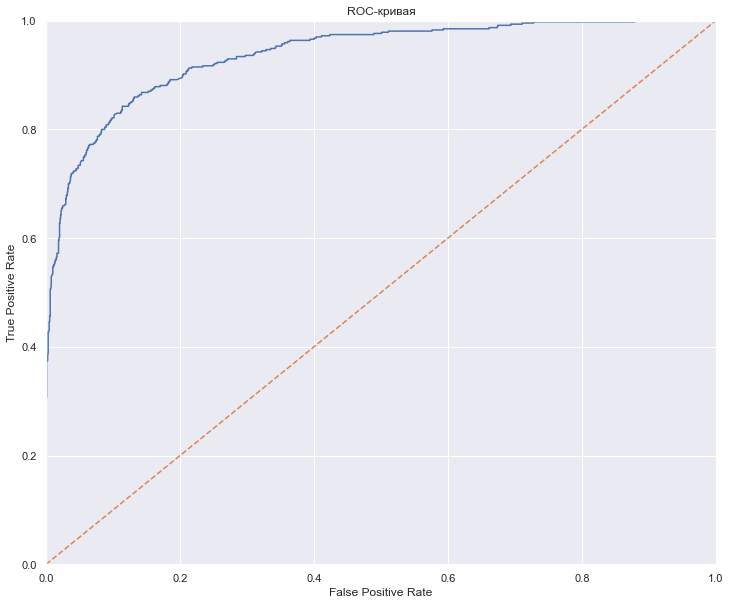

In [88]:
draw_ROC(target_test, features_test, grid_searcher_LGMB_roc)

### Выводы

###### В проекте выполнены следующие этапы

1. Первичное знакомство с данными/загрузка данных
- загружены библиотеки и данные
- данные изучены, определена необходимость их предобработки и исследования
2. Предобработка данных/исследовательский анализ данных
- заполнены пропуски и изменены типы данных
- создан новый признак: продолжительность контракта с клиентом duration_contract
- выделен целевой признак client_left: уйдет клиент или нет 
- данные обьединены в единый датасет
- проведен анализ распределения признаков, опредена их их важность для обучении моделей
- удалены ненужные признаки для обучения моделей

Итоговый список признаков:
- billing_type      
- paperless_billing  
- payment_method     
- senior_sitizen     
- partner            
- dependents         
- internet_service   
- online_security    
- online_backup      
- device_protection  
- tech_support       
- streaming_tv       
- streaming_movies   
- multiple_lines     
- duration_contract (новый созданный признак) 
3. Моделирование
- данные разделенны на треновочный и тестовый наборы 
- выполнено кодирование и масштабирование данных
- при обучении моделей применена балансировка целевого признака class_weight='balanced'
- выполнены подбор гиперпараметров, обучение, оценка качества по метрике ROC_AUC
на кросс-валидации для трех моделей LGBMClassifier, LogisticRegression и XGBClassifier
- лучшую метрику качества ROC_AUC показала модель LGBMClassifier - 0.933
- значение метрики Accuracy на моделе LGBMClassifier - 0.858

Гиперпараметры LGBMRegressor: 
- class_weight='balanced',
- learning_rate=0.155,
- max_depth=2,
- n_estimators=1190,
- l2_leaf_reg=1, 
- random_state=121222,
- cv=6
 
4. Тестирование 
- выпонено тестирование лучшей модели LGBMClassifier на тестовой выборке
- метрика качества ROC_AUC модели LGBMClassifier на тестовой выборке - 0.862
- метрики качества Accuracy на моделе LGBMClassifier на тестовой выборке - 0.860

###### Модель бинарной классификации LGBMClassifier может быть рекомендована оператору связи для прогнозирования оттока клиентов с целью принятия упреждающих мер по удержанию клиентов 

### Отчет по представленному решению

1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Все пункты плана решения задачи выполнены.

2. Какие трудности возникли и как вы их преодолели?

Особых трудностей не было. Много времени ушло на подбор гиперпараметров моделей для получения высокого качества метрик.

3. Какие ключевые шаги в решении задачи выделили?
- подготовка данных, заполнение пропусков, создание нового признака, объединение
- анализ данных, выделение целевого признака
- отбор признаков для обучения
- подбор гиперпараметров, обучение моделей
- выбор лучшей модели по результатам кросс-валидации, тестирование.

4. Какая ваша итоговая модель и какое у неё качество?

Итоговая модель LGBMClassifier показала следущие метрики качества:
- на кросс-валидации ROC AUC: 0.933
- на кросс-валидации Accuracy: 0.858
- на тестовых данных ROC AUC: 0.862
- на тестовых данных Accuracy: 0.860

Данные метрики качества модели LGBMClassifier получены на гиперпараметрах:
- class_weight='balanced',
- learning_rate=0.155,
- max_depth=2,
- n_estimators=1190,
- l2_leaf_reg=1, 
- random_state=121222
- cv=6

Данные метрики качества модели LGBMClassifier получены на итоговых признаках:
- billing_type      
- paperless_billing  
- payment_method     
- senior_sitizen     
- partner            
- dependents         
- internet_service   
- online_security    
- online_backup      
- device_protection  
- tech_support       
- streaming_tv       
- streaming_movies   
- multiple_lines     
- duration_contract  (новый созданный признак - продолжительность контракта с клиентом)

Для итоговых признаков проведена следующая преобработка:
- создан новый признак продолжительность контракта с клиентом duration_contract. Признак рассчитывается как разница между датами окончания пользования услугами end_date и датой начала пользования услугами begin_date. Перед этим, данные в столбце end_date с обозначением 'No' заменили на дату выгрузки данных '2020-02-01'. Замена сделана на предположении, что отсутствие даты в столбце end_date означает, что на момент выгрузки данных договор не с клиентом расторгнут
- пропуски значений в столбцах с услугами online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies заменили на обозначение 'No', предположив что услуги не предоставляется 
- пропуски значений в столбце multiple_lines заменили на обозначение 'No', предположив что данные клиенты не имеют подключения по мультиканальной линии
- пропуски значений в столбце internet_service заменили на обозначение 'Не используется', предположив что данные клиенты не используются интернет сервисом